In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import openpyxl

pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Only keep relevant
        df = df[["chr", "gene_id", "gene_name"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Drop "other" column
        df = df[["chr", "gene_id"]].copy()
        
    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [3]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df):

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in ["total_counts"]:
        
        df[col] = df[col]
        cpm_name = "average_CPM"
        df[cpm_name] = ((df[col]/(df[col].sum())) * 1000000)
    
    return df 

In [4]:
## Import transcripts
df_transcripts = pd.read_csv("../../data/raw/merged_aged_stringent/bambu_discovery/counts_transcript.txt",
        sep="\t", low_memory=False, header=0)

In [5]:
## Import Genes
df_genes = pd.read_csv("../../data/raw/merged_aged_stringent/bambu_discovery/counts_gene.txt",
        sep="\t", low_memory=False, header=0)

In [6]:
## Get total counts for genes and transcripts
df_genes["total_counts"] = df_genes[df_genes.columns[1:]].sum(axis=1)
df_transcripts["total_counts"] = df_transcripts[df_transcripts.columns[2:]].sum(axis=1)

In [7]:
## Get average counts for genes and transcripts
df_genes["average_counts"] = df_genes["total_counts"]/4
df_transcripts["average_counts"] = df_transcripts["total_counts"]/4

In [8]:
## Only keep genes and transcripts with more than 0 counts
df_genes = df_genes.loc[df_genes["total_counts"] > 0].copy()
df_transcripts = df_transcripts.loc[df_transcripts["total_counts"] > 0].copy()

In [9]:
## Calculate percentile
df_genes['percentile'] = df_genes["total_counts"].rank(pct=True)

In [10]:
## Calculate Rank
df_genes['rank'] = df_genes["total_counts"].rank(ascending=False)

In [11]:
## See rank for  PIEZO1P1 
## Respectively: ENSG00000233686
df_genes.loc[df_genes.index.str.contains("ENSG00000142192")]

,cshl_356_uky_mapped_filtered_sorted,cshl_1291_uky_mapped_filtered_sorted,cshl_1304_uky_mapped_filtered_sorted,cshl_1271_uky_mapped_filtered_sorted,total_counts,average_counts,percentile,rank
ENSG00000142192,44627,30588,52703,70702,153993,38498.25,0.996161,199.0


In [12]:
## Get total counts for all genes with more than 0 counts
total_counts = df_genes["total_counts"]

In [13]:
## Get log total counts
log_total_counts = np.log10(df_genes["total_counts"])

In [14]:
print("APP Log Expression:", log_total_counts["ENSG00000142192"])

APP Log Expression: 5.1875009797295295


In [16]:
np.log10(5)

0.6989700043360189

In [17]:
## Use ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

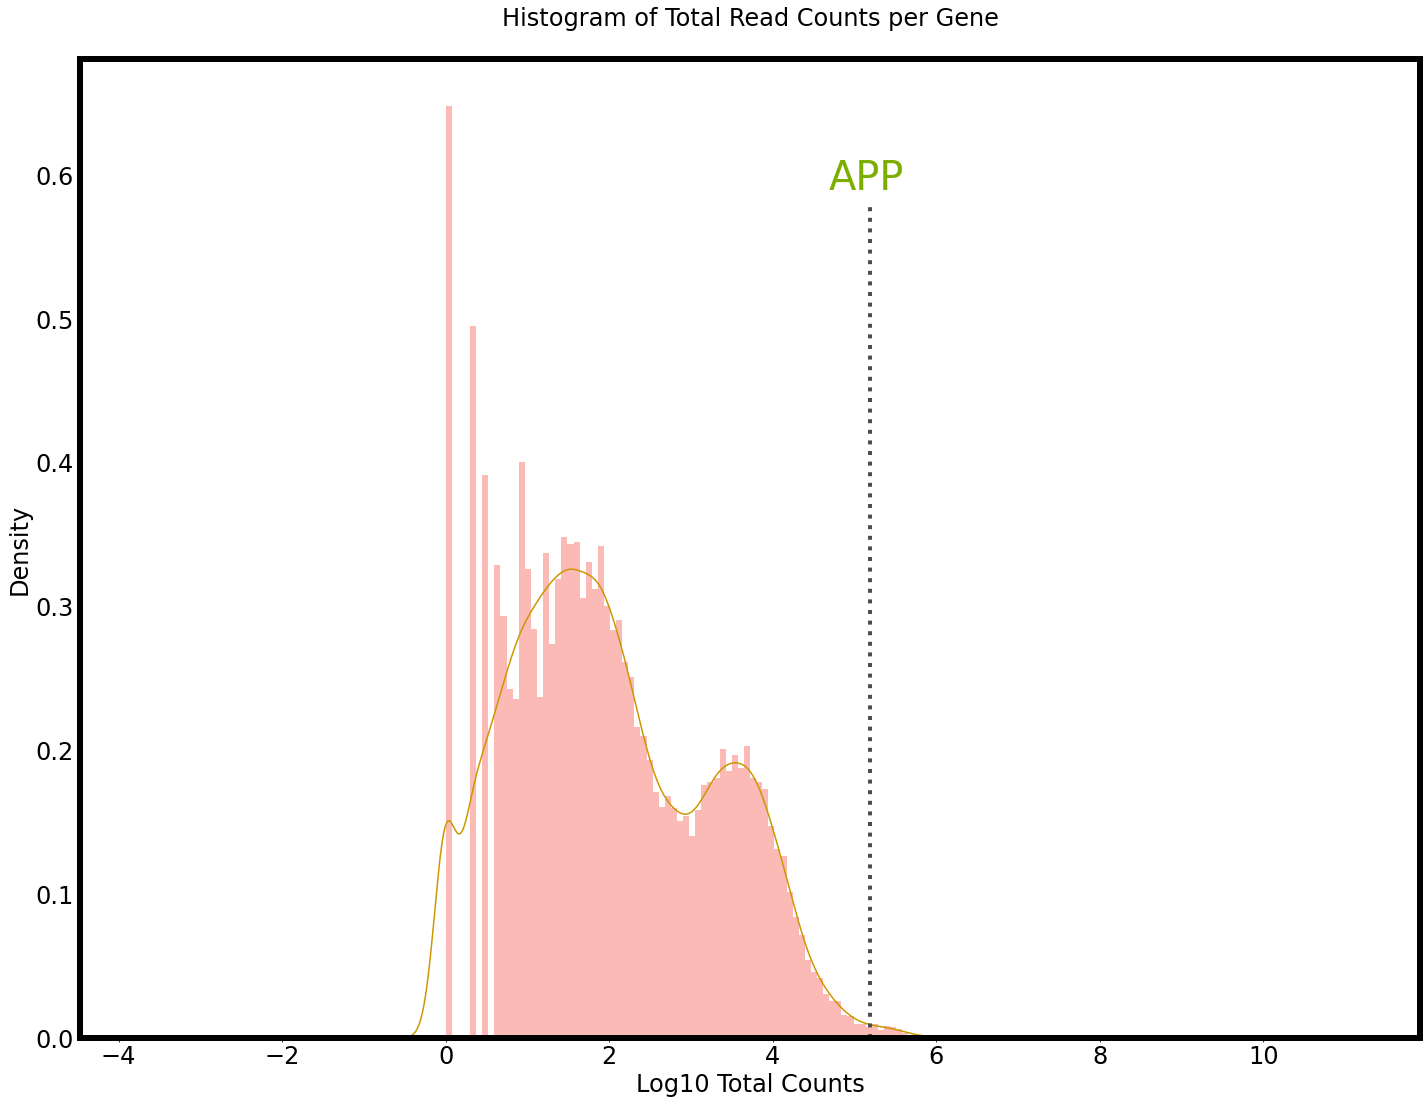

In [22]:
## Create log plot
## Set parameters for figures
from matplotlib import rcParams



fig, ax = plt.subplots(figsize = (24,18))
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6


log_total_counts.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density


log_total_counts.plot(kind = "kde", color="#CD9600", alpha=1)

ax.set_xlabel("Log10 Total Counts", size=24)


ax.set_title("Histogram of Total Read Counts per Gene\n", size=24)

ax.axvline(5.19, alpha=1, ymax = 0.85, linestyle = ":", color="#4d4d4d", linewidth=4)

ax.text(5.19 - 0.5, 0.59, "APP", size = 40, alpha = 1, color="#7CAE00")

plt.savefig('/home/bag222/app_histogram.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('/home/bag222/app_histogram.png',
            dpi=300, transparent=True, bbox_inches="tight")


plt.show()

In [23]:
df_genes_cpm = calculate_cpm(df_genes)

In [24]:
df_genes_cpm.head()

,cshl_356_uky_mapped_filtered_sorted,cshl_1291_uky_mapped_filtered_sorted,cshl_1304_uky_mapped_filtered_sorted,cshl_1271_uky_mapped_filtered_sorted,total_counts,average_counts,percentile,rank,average_CPM
ENSG00000000003,476,660,969,868,2497,624.25,0.823485,9106.0,9.571391
ENSG00000000005,16,20,31,23,74,18.50,0.508656,25345.5,0.283654
ENSG00000000419,2930,2061,4146,6086,12293,3073.25,0.946163,2778.0,47.120990
ENSG00000000457,549,377,700,420,1497,374.25,0.782986,11195.0,5.738235
ENSG00000000460,158,109,227,157,493,123.25,0.707446,15091.5,1.889746


In [27]:
## Get total counts for all genes with more than 0 counts
total_cpm = df_genes_cpm["average_CPM"]

In [28]:
## Get log total counts
log_total_cpm = np.log10(df_genes_cpm["average_CPM"])

In [29]:
print("APP Log Expression:", log_total_cpm["ENSG00000142192"])

APP Log Expression: 2.7710575020733


In [30]:
df_genes_cpm.loc[df_genes_cpm.index == "ENSG00000142192"]

,cshl_356_uky_mapped_filtered_sorted,cshl_1291_uky_mapped_filtered_sorted,cshl_1304_uky_mapped_filtered_sorted,cshl_1271_uky_mapped_filtered_sorted,total_counts,average_counts,percentile,rank,average_CPM
ENSG00000142192,44627,30588,52703,70702,153993,38498.25,0.996161,199.0,590.27923


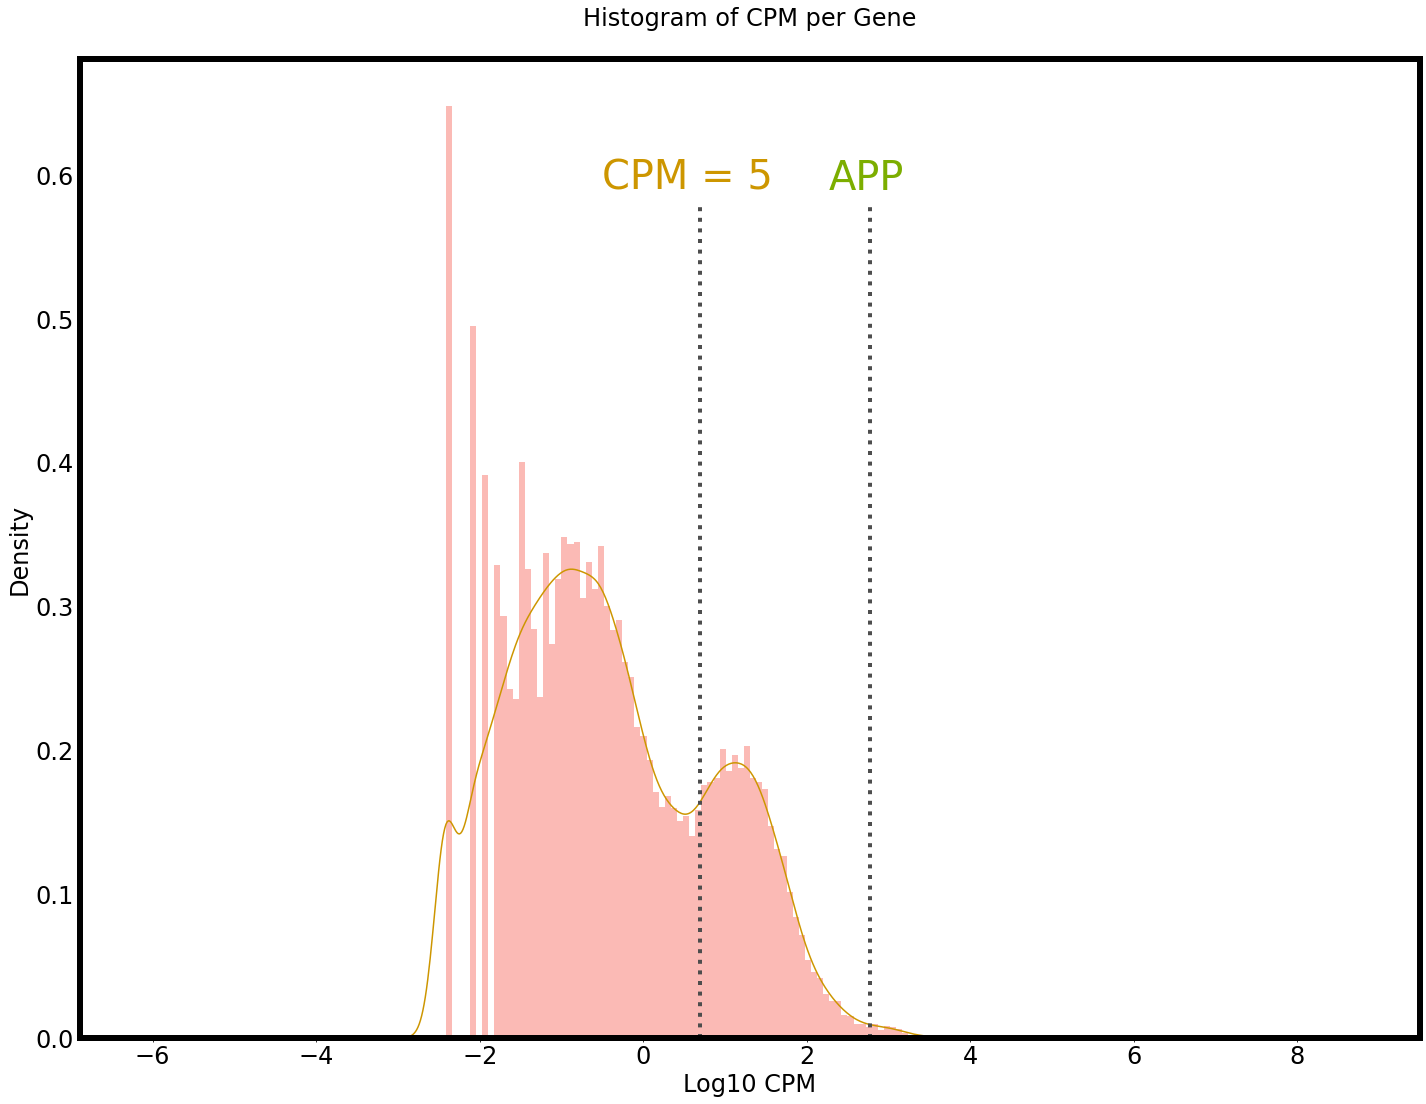

In [35]:
## Create log plot
## Set parameters for figures
from matplotlib import rcParams



fig, ax = plt.subplots(figsize = (24,18))
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6


log_total_cpm.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density


log_total_cpm.plot(kind = "kde", color="#CD9600", alpha=1)

ax.set_xlabel("Log10 CPM", size=24)


ax.set_title("Histogram of CPM per Gene\n", size=24)

ax.axvline(2.77, alpha=1, ymax = 0.85, linestyle = ":", color="#4d4d4d", linewidth=4)
ax.axvline(0.698, alpha=1, ymax = 0.85, linestyle = ":", color="#4d4d4d", linewidth=4)



ax.text(2.77 - 0.5, 0.59, "APP", size = 40, alpha = 1, color="#7CAE00")
ax.text(0.698 - 1.2, 0.59, "CPM = 5", size = 40, alpha = 1, color="#CD9600")

plt.savefig('/home/bag222/app_histogram_cpm.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('/home/bag222/app_histogram_cpm.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [22]:
df_transcripts.head()

,TXNAME,GENEID,cshl_356_uky_mapped_filtered_sorted,cshl_1291_uky_mapped_filtered_sorted,cshl_1304_uky_mapped_filtered_sorted,cshl_1271_uky_mapped_filtered_sorted,total_counts,average_counts
0,tx.1,ENSG00000078808,638.547019,570.311659,918.306555,545.271793,2672.437026,668.109257
1,tx.2,ENSG00000008130,86.895137,157.979474,89.532209,135.226654,469.633474,117.408369
2,tx.3,gene.4578,28.000000,162.000000,67.000000,69.000000,326.000000,81.500000
3,tx.4,ENSG00000116663,89.692718,43.156208,154.145707,71.295613,358.290246,89.572562
4,tx.5,gene.5343,45.000000,51.000000,26.000000,28.000000,150.000000,37.500000


In [23]:
df_transcripts.columns = ["TXNAME", "GENEID", "356_counts", "1291_counts", "1304_counts", "1271_counts",
                          "total_counts", "average_counts"]

In [26]:
df_t_cpm = calculate_cpm(df_transcripts)

In [29]:
## Look at PIEZO1P1 expression
print("PIEZO1P1")
df_t_cpm.loc[df_t_cpm["GENEID"].str.contains("ENSG00000233686")].sort_values(by="average_CPM", ascending=False)

PIEZO1P1


,TXNAME,GENEID,356_counts,1291_counts,1304_counts,1271_counts,total_counts,average_counts,average_CPM
89442,ENST00000485427,ENSG00000233686,0.0,3.0,16.0,12.0,31.0,7.75,0.09


In [30]:
## Look at PIEZO1P2 expression
print("PIEZO1P2")
df_t_cpm.loc[df_t_cpm["GENEID"].str.contains("ENSG00000237121")].sort_values(by="average_CPM", ascending=False)

PIEZO1P2


,TXNAME,GENEID,356_counts,1291_counts,1304_counts,1271_counts,total_counts,average_counts,average_CPM
42088,ENST00000416241,ENSG00000237121,223.0,94.0,174.0,59.0,550.0,137.5,1.64
